In [ ]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz", "data.tgz")

!tar -xzvf data.tgz
!mv /content/20news-bydate/matlab/train.data /content/

20news-bydate/matlab/
20news-bydate/matlab/train.data
20news-bydate/matlab/train.label
20news-bydate/matlab/train.map
20news-bydate/matlab/test.data
20news-bydate/matlab/test.label
20news-bydate/matlab/test.map


In [ ]:
import random
import sys
from operator import itemgetter

In [ ]:
f = open("train.data","r")
input = f.readlines()
for i in range(len(input)):
  input[i] = list(map(int,input[i].split()[1:]))

In [ ]:
class HashFunction:
  def __init__(self, a, p, d, b=None, f=None, h=None):
    self.a = a
    self.p = p
    self.d = d
    self.b = b
    self.f = f
    self.h = h
  def getHash(self,x):
    return ((self.a*x+self.b)%self.p)%d
  def hashG(self,x):
    sign = ((self.f*x+self.h)%self.p)%2
    return sign if sign>0 else -1

In [ ]:
k = [100, 200, 500, 1000, 2000, 30000, 100000]
w = 5 # Number of Hash Functions

In [ ]:
# Count Min Sketch
CMS_errors = []
def query(Count_Min,q):
  min_count = sys.maxsize
  for i in range(w):
    min_count = min(min_count,Count_Min[i][hashes[i].getHash(q)])
  return min_count

p = 2**31-1
for ki in k:
  hashes = []
  d = ki//w
  for i in range(w):
    hashes.append(HashFunction(random.randint(1,p-1), p, d, b=random.randint(1,p-1)))
  Count_Min = [[0 for i in range(d)] for j in range(w)]
  total_len = len(input)
  cnt = 0
  for word in input:
    cnt+=1
    if cnt%10000==0:
      print(f"\rProgress for k = {ki}: "+str(cnt*100/total_len)[:5]+"%",end="")
    for j in range(w):
      Count_Min[j][hashes[j].getHash(word[0])]+=word[1]
  print()

  vocab = {} # Vocab length is 53975
  for word in input:
    if word[0] not in vocab:
      vocab[word[0]]=word[1]
    else:
      vocab[word[0]]+=word[1]

  listOfWords = []
  for word in vocab.keys():
    listOfWords.append([word,vocab[word]])

  listOfWords.sort(key=itemgetter(1),reverse=True)
  TopWords = listOfWords[:1000]
  Top100 = random.sample(TopWords, 100)
  err = 0
  for i in Top100:
    err+=abs(i[1]-query(Count_Min,i[0]))/i[1]
  CMS_errors.append(err)
  print(f"Error for k = {ki}:",err)

Progress for k = 100: 99.49%
Error for k = 100: 15521.47732956976
Progress for k = 200: 99.49%
Error for k = 200: 7277.378549804717
Progress for k = 500: 99.49%
Error for k = 500: 2248.442250727611
Progress for k = 1000: 99.49%
Error for k = 1000: 995.8700195204055
Progress for k = 2000: 99.49%
Error for k = 2000: 446.39310188499513
Progress for k = 30000: 99.49%
Error for k = 30000: 7.252695062399013
Progress for k = 100000: 99.49%
Error for k = 100000: 0.6895404352839045


Count Min Sketch gets an error of less than 1% for k>100000.


In [ ]:
# Count Sketch
CS_errors = []
def query(Count_Min,q):
  counts = []
  for i in range(w):
    counts.append(Count_S[i][hashes[i].getHash(q)]*hashes[i].hashG(q))
  counts.sort()
  return counts[2]

p = 2**31-1
for ki in k:
  hashes = []
  d = ki//w
  for i in range(w):
    hashes.append(HashFunction(random.randint(1,p-1), p, d, b=random.randint(1,p-1), f=random.randint(1,p-1), h=random.randint(1,p-1)))
  Count_S = [[0 for i in range(d)] for j in range(w)]
  total_len = len(input)
  cnt = 0
  for word in input:
    cnt+=1
    if cnt%10000==0:
      print(f"\rProgress for k = {ki}: "+str(cnt*100/total_len)[:5]+"%",end="")
    for j in range(w):
      Count_S[j][hashes[j].getHash(word[0])]+=(word[1]*hashes[j].hashG(word[0]))
  print()

  vocab = {} # Vocab length is 53975
  for word in input:
    if word[0] not in vocab:
      vocab[word[0]]=word[1]
    else:
      vocab[word[0]]+=word[1]

  listOfWords = []
  for word in vocab.keys():
    listOfWords.append([word,vocab[word]])

  listOfWords.sort(key=itemgetter(1),reverse=True)
  TopWords = listOfWords[:1000]
  Top100 = random.sample(TopWords, 100)
  err = 0
  for i in Top100:
    err+=abs(i[1]-query(Count_S,i[0]))/i[1]
  CS_errors.append(err)
  print(f"Error for k = {ki}:",err)

Progress for k = 100: 99.49%
Error for k = 100: 2336.7687794322005
Progress for k = 200: 99.49%
Error for k = 200: 894.6498528090423
Progress for k = 500: 99.49%
Error for k = 500: 456.68338724095975
Progress for k = 1000: 99.49%
Error for k = 1000: 235.2301261395869
Progress for k = 2000: 99.49%
Error for k = 2000: 165.16181427971085
Progress for k = 30000: 99.49%
Error for k = 30000: 5.217860245533762
Progress for k = 100000: 99.49%
Error for k = 100000: 0.8332586516842623


Count Sketch gets an error of less than 1% for k>100000.


In [ ]:
# Misra Gries
MG_errors = []
for ki in k:
  Counters = {}
  nums = 0
  for i in input:
    if i[0] in Counters:
      Counters[i[0]] += i[1]
    elif nums<ki:
      Counters[i[0]] = i[1]
      nums+=1
    else:
      min_count = sys.maxsize
      nums_init = nums
      keys = list(Counters.keys())
      for j in keys:
        if Counters[j]<=i[1]:
          min_count = min(min_count,Counters[j])
      for j in keys:
        if Counters[j]==min_count:
          Counters.pop(j)
          nums-=1
      for j in Counters.keys():
        Counters[j]-=min_count
      if nums_init==nums:
        pass
      else:
        Counters[i[0]] = i[1]-min_count
        nums+=1

  listOfWords = []
  for word in vocab.keys():
    listOfWords.append([word,vocab[word]])

  listOfWords.sort(key=itemgetter(1),reverse=True)
  TopWords = listOfWords[:1000]
  Top100 = random.sample(TopWords, 100)
  err = 0
  for i in Top100:
      if i[0] in Counters:
          err+=abs(i[1]-Counters[i[0]])/i[1]
      else:
          err+=1
  MG_errors.append(err)
  print(f"Error for k = {ki}:",err)

Error for k = 100: 99.5003929113868
Error for k = 200: 98.8622646646073
Error for k = 500: 95.48775438473308
Error for k = 1000: 89.35082546639964
Error for k = 2000: 70.67960646058553
Error for k = 30000: 1.0946257391529732
Error for k = 100000: 0.0


Misra Gries Sketch gets an error of less than 1% for k>30000.




In [ ]:
print(CMS_errors)
print(CS_errors)
print(MG_errors)

[15521.47732956976, 7277.378549804717, 2248.442250727611, 995.8700195204055, 446.39310188499513, 7.252695062399013, 0.6895404352839045]
[2336.7687794322005, 894.6498528090423, 456.68338724095975, 235.2301261395869, 165.16181427971085, 5.217860245533762, 0.8332586516842623]
[99.5003929113868, 98.8622646646073, 95.48775438473308, 89.35082546639964, 70.67960646058553, 1.0946257391529732, 0.0]


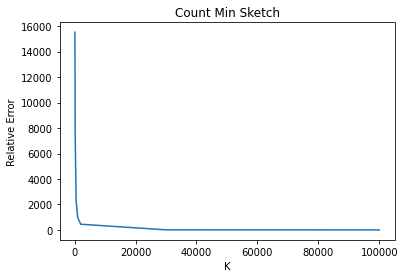

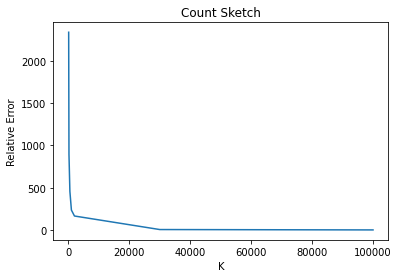

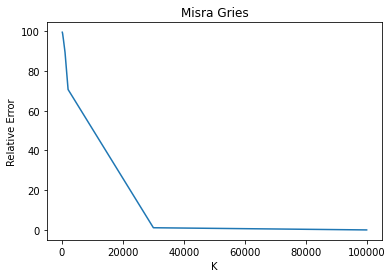

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k, CMS_errors)
plt.xlabel('K')
plt.ylabel('Relative Error')
plt.title('Count Min Sketch')
plt.show()

plt.plot(k, CS_errors)
plt.xlabel('K')
plt.ylabel('Relative Error')
plt.title('Count Sketch')
plt.show()

plt.plot(k, MG_errors) 
plt.xlabel('K')
plt.ylabel('Relative Error')
plt.title('Misra Gries')
plt.show()